In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
import numpy as np 
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.densenet import DenseNet121
#from google.colab import drive #Google colab için
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


In [2]:
def combine(models):
    a = models[0]
    b = models[1]
    concatenate = Concatenate()([a.output,b.output])
    x = Dense(512, activation = 'relu')(concatenate)
    x = Dropout(0.4)(x)
    output = Dense(1)(x)
    model_concat = Model(a.input, output)
    return model_concat

In [3]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor=(-0.0,-0.2))
])

pretrained_model_vgg = VGG16(weights='imagenet',include_top=False ,input_shape=(512,512,3))
pretrained_model_dense = DenseNet121(weights='imagenet',include_top=False ,input_shape=(512,512,3))

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=(512, 512, 3))
x = data_augmentation(inputs)
x = pretrained_model_vgg(x, training=False)
outputs_1 = global_average_layer(x)
m_1=Model(inputs,outputs_1)

x = data_augmentation(inputs)
x = pretrained_model_dense(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs_2 = tf.keras.layers.Dense(units=512,activation='relu')(x)
m_2 = Model(inputs,outputs_2)

In [4]:
m_1.trainable = False
m_2.trainable= False
models = [m_1,m_2]
m = combine(models)
m.load_weights('./models/fullyconnected_dense+vgg.h5')
m.trainable = False

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 512, 512, 3)  0           input_3[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Functional)              (None, 16, 16, 512)  14714688    sequential[0][0]                 
__________________________________________________________________________________________________
densenet121 (Functional)        (None, 16, 16, 1024) 7037504     sequential[1][0]           

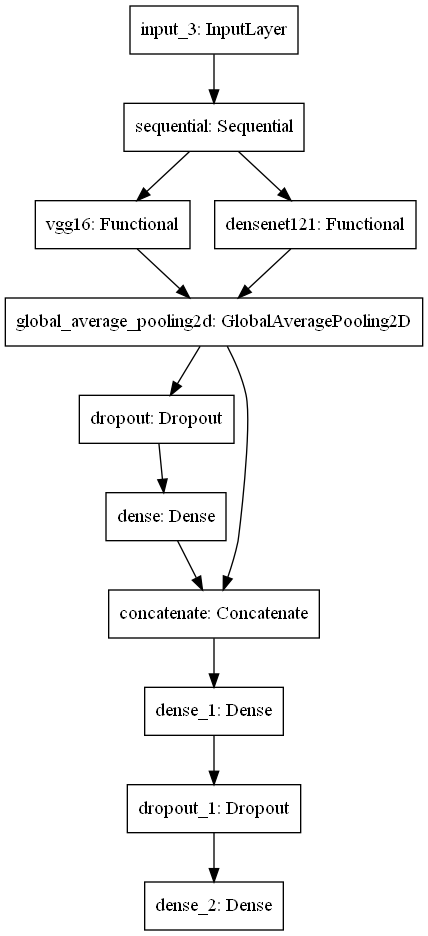

In [5]:
m.summary()
tf.keras.utils.plot_model(m, to_file='evalmodel.png')

In [6]:
train_normal_dir=os.path.join('./data/train/normal')
train_PNEUMONIA_dir=os.path.join('./data/train/anormal')
test_normal_dir=os.path.join('./data/test/normal')
test_PNEUMONIA_dir=os.path.join('./data/test/anormal')
val_normal_dir=os.path.join('./data/val/normal')
val_PNEUMONIA_dir=os.path.join('./data/val/anormal')

In [104]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 10
train_datagen = ImageDataGenerator(rescale = 1./255)

train_generator=train_datagen.flow_from_directory(
      './data/train/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary'
)
train_dataset = image_dataset_from_directory('./data/train/',
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=(512,512))


test_datagen=ImageDataGenerator(rescale=1./255)
test_generator=train_datagen.flow_from_directory(
      './data/test/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary',
      shuffle=True
)
test_dataset = image_dataset_from_directory('./data/test/',
                                             shuffle=False,
                                             batch_size=BATCH_SIZE,
                                             image_size=(512,512))

val_datagen=ImageDataGenerator(rescale=1./255)
val_generator=train_datagen.flow_from_directory(
      './data/val/',
      target_size=(512,512),
      batch_size=BATCH_SIZE,
      class_mode='binary'
)
validation_dataset = image_dataset_from_directory('./data/val/',
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=(512,512))



Found 6356 images belonging to 2 classes.
Found 6356 files belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 140 files belonging to 2 classes.
Found 140 images belonging to 2 classes.
Found 140 files belonging to 2 classes.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [16]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

test_data = test_dataset.take(20)
score = 0
photo_amount = 0
for photo in test_data:
    pred_list = m.predict(photo[0])
    for i, pred in enumerate(pred_list):
        photo_amount += 1
        pred = np.round(sigmoid(pred))
        label = photo[1][i]
        if pred == label:
            score += 1
print(score)
print(photo_amount)
print(score/photo_amount)

132
140
0.9428571428571428


In [134]:
def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

test_dataset = test_dataset.shuffle(1000, reshuffle_each_iteration=True)
test_data = test_dataset.take(20)
score = 0
photo_amount = 0
all_pred_list = []
all_label_list = []
all_photo_list = []
for photo in test_data:
    pred_list = m.predict(photo[0])
    for p in photo[0]:
        all_photo_list.append(p)
    for i, pred in enumerate(pred_list):
        photo_amount += 1
        pred = np.round(sigmoid(pred))
        all_pred_list.append(int(pred[0]))
        label = photo[1][i]
        all_label_list.append(int(label.numpy()))
        if pred == label:
            score += 1
print(score)
print(photo_amount)
print(score/photo_amount)

132
140
0.9428571428571428


['anormal', 'normal']


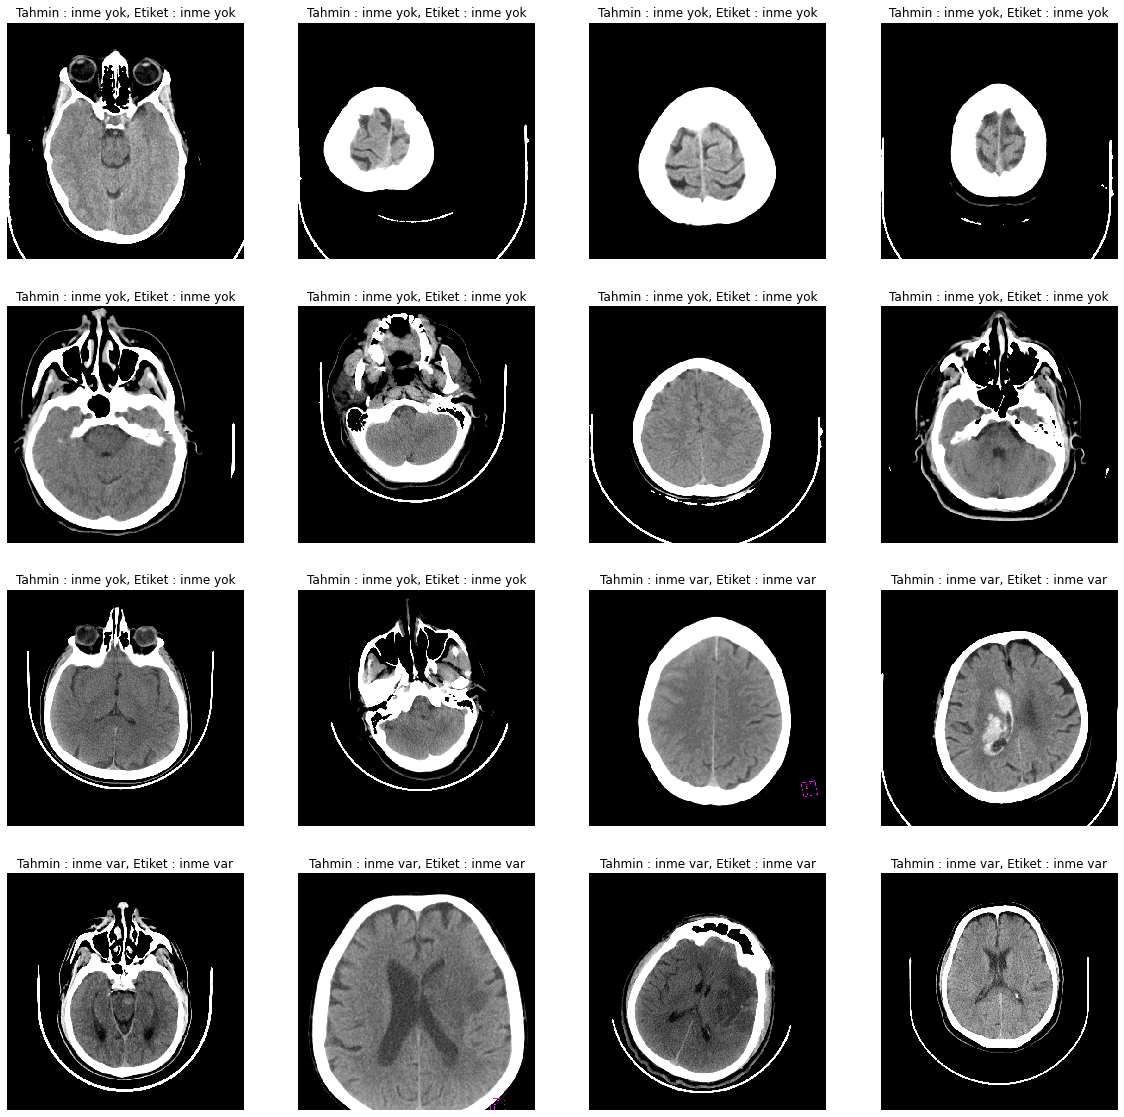

In [145]:
plt.figure(figsize=(20, 20))
names = ["inme var", "inme yok"]
print(train_dataset.class_names)
for i, photo in enumerate(all_photo_list[0:16]):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(photo.numpy().astype("uint8"), cmap='gray', interpolation='none')
    plt.title("Tahmin : {}, Etiket : {}".format(names[all_pred_list[i]], names[all_label_list[i]]))
    plt.axis("off")
plt.savefig('output.png', facecolor="white", transparent=False)
